## Preparing the Ground

In [1]:
# Initial setup cell
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## Loading and Understanding the Data

In [2]:
# --- Loading Data with the Magic of TFDS ---
# TFDS downloads, splits the data, and delivers it all ready.
(train_dataset_raw, validation_dataset_raw), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'], # 80% for training, 20% for validation
    with_info=True,
    as_supervised=True, # Returns data as (image, label) pairs
)

# --- Exploring the Data ---
num_classes = metadata.features['label'].num_classes
class_names = metadata.features['label'].names
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.QOR0N3_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Number of classes: 2
Class names: ['cat', 'dog']


## Preprocessing (Cleaning and Optimizing the Input)

In [3]:
# --- Defining Global Parameters ---
IMG_SIZE = 128
BATCH_SIZE = 32

# --- Formatting Function ---
def format_image(image, label):
  """Resizes and normalizes the image."""
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = image / 255.0
  return image, label

# --- Applying the Formatting ---
train_dataset = train_dataset_raw.map(format_image)
validation_dataset = validation_dataset_raw.map(format_image)

# --- Optimization and Batching ---
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

print("\nDatasets ready for training!")


Datasets ready for training!


## Building the Network

In [4]:
# --- Data Augmentation Layer ---
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
])

# --- Building the Model ---
model_base = tf.keras.models.Sequential([
    # The input gate of our network.
    tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),

    # 1. Apply Data Augmentation (ONLY during training)
    data_augmentation,

    # --- Block 1: The Low-Level Detective ---
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # --- Block 2: The Mid-Level Detective ---
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # --- Block 3: The High-Level Detective ---
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # --- The Bridge: From Vision to Decision ---
    tf.keras.layers.Flatten(),

    # --- The Rational Brain: Decision Making ---
    tf.keras.layers.Dense(64, activation='relu'),
    # To further combat overfitting, a Dropout layer here is also a great idea.
    tf.keras.layers.Dropout(0.5),

    # --- The Output: The Final Verdict ---
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_base.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,009 (6.48 MB)

 Trainable params: 1,699,009 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

## Compiling the Model

In [5]:
model_base.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Training the Model

In [6]:
EPOCHS = 15

history = model_base.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset
)

Epoch 1/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.5864 - loss: 0.6678 - val_accuracy: 0.6870 - val_loss: 0.5754
Epoch 2/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.6948 - loss: 0.5827 - val_accuracy: 0.7489 - val_loss: 0.5148
Epoch 3/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.7427 - loss: 0.5267 - val_accuracy: 0.7872 - val_loss: 0.4663
Epoch 4/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7628 - loss: 0.4928 - val_accuracy: 0.8050 - val_loss: 0.4235
Epoch 5/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.7868 - loss: 0.4643 - val_accuracy: 0.8126 - val_loss: 0.4151
Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7994 - loss: 0.4414 - val_accuracy: 0.8235 - val_loss: 0.3866
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.8099 - loss: 0.4214 - val_accuracy: 0.8388 - val_loss: 0.3722
Epoch 8/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.8224 - loss: 0.4048 - 

## Evaluating the model

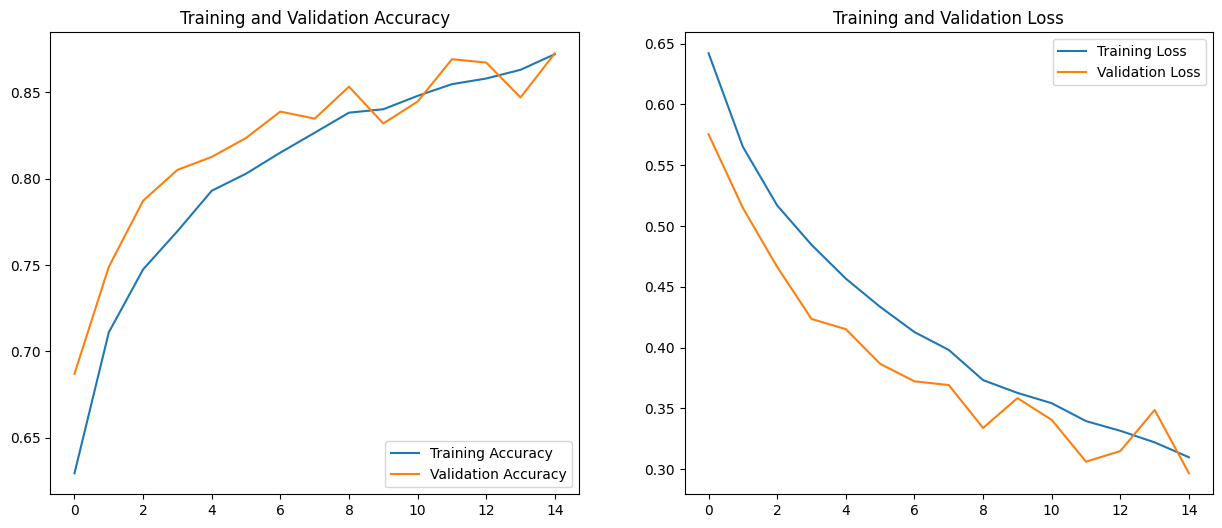

Dog and Cat specialist model saved successfully!


In [7]:
# --- Visualizing the Learning ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# --- Saving the Acquired Knowledge ---
model_base.save('cats_vs_dogs_base_model.keras')
print("Dog and Cat specialist model saved successfully!")

## Testing the model

Saving Dog.jpg to Dog.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Prediction: Dog (Confidence: 62.40%)


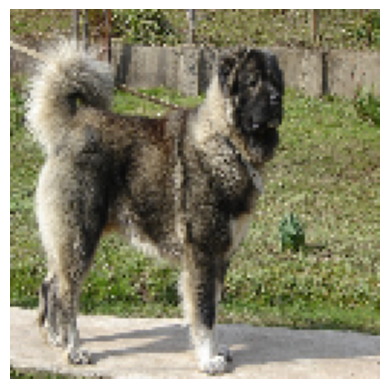

In [8]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# --- Uploading the Image ---
uploaded = files.upload()

# Get the name of the uploaded file
for fn in uploaded.keys():

  # --- Loading and Preprocessing the Image ---
  # The model needs to receive the data in EXACTLY the same format as the training.
  path = fn
  img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
  img_array = img_to_array(img)
  img_array = img_array / 255.0 # Normalization

  # The model expects a "batch" of images. We create a batch with a single image.
  img_batch = np.expand_dims(img_array, axis=0)

  # --- Making the Prediction ---
  prediction = model_base.predict(img_batch)

  # --- Interpreting the Result ---
  plt.imshow(img)
  plt.axis("off")

  if prediction[0][0] > 0.5:
    print(f"Prediction: Dog (Confidence: {prediction[0][0]*100:.2f}%)")
  else:
    print(f"Prediction: Cat (Confidence: {prediction[0][0]*100:.2f}%)")

## Reusing the Brain

In [9]:
# Loads the trained brain of our specialist
loaded_cats_vs_dogs_model = tf.keras.models.load_model('cats_vs_dogs_base_model.keras')

# --- The Magic Step: Freezing ---
# We tell the model: "Don't change anything you already know."
loaded_cats_vs_dogs_model.trainable = False

## Adapting to the New Task

In [10]:
# --- Loading the new dataset: Flowers ---
(train_flowers_raw, validation_flowers_raw), metadata_flowers = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes_flowers = metadata_flowers.features['label'].num_classes
print(f"The new dataset has {num_classes_flowers} flower classes.")

# --- Preprocessing the flower data ---
# We use the same formatting function and the same parameters
train_flowers = train_flowers_raw.map(format_image)
validation_flowers = validation_flowers_raw.map(format_image)

train_flowers = train_flowers.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
validation_flowers = validation_flowers.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.MX2SPF_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
The new dataset has 5 flower classes.


## Adapting the Specialist

In [11]:
# Loads the trained brain of our specialist
loaded_cats_vs_dogs_model = tf.keras.models.load_model('cats_vs_dogs_base_model.keras')

# --- The Magic Step: Freezing ---
# We tell the model: "Don't change anything you already know about images."
loaded_cats_vs_dogs_model.trainable = False

# --- Adapting the Architecture ---
# The base of our new model is the frozen specialist, but without its last decision layer.
frozen_base = tf.keras.models.Sequential(loaded_cats_vs_dogs_model.layers[:-1])

# We create a new decision "head" for the 5 flower classes.
# We use 'softmax' for problems with more than 2 classes.
new_flower_head = tf.keras.layers.Dense(num_classes_flowers, activation='softmax', name='flower_output')

# We join the frozen base with the new head
transfer_model = tf.keras.models.Sequential([
    frozen_base,
    new_flower_head
])

# See the magic in the summary:
transfer_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 64)             │     1,698,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flower_output (Dense)           │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,269 (6.48 MB)

 Trainable params: 325 (1.27 KB)

 Non-trainable params: 1,698,944 (6.48 MB)

## Compiling and Training the New Model

In [12]:
# We compile with a new loss function for multiple classes
transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# We train only the new head, using the flower data.
# Generally, we need fewer epochs for transfer learning.
EPOCHS_TRANSFER = 15

history_transfer = transfer_model.fit(
    train_flowers,
    epochs=EPOCHS_TRANSFER,
    validation_data=validation_flowers
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.1819 - loss: 1.9537 - val_accuracy: 0.2098 - val_loss: 1.6445
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.1970 - loss: 1.7808 - val_accuracy: 0.2221 - val_loss: 1.6032
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2372 - loss: 1.7003 - val_accuracy: 0.2670 - val_loss: 1.5787
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2492 - loss: 1.6531 - val_accuracy: 0.2807 - val_loss: 1.5624
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2602 - loss: 1.6365 - val_accuracy: 0.2861 - val_loss: 1.5518
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2765 - loss: 1.6076 - val_accuracy: 0.3120 - val_loss: 1.5418
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2705 - loss: 1.5886 - val_accuracy: 0.3311 - val_loss: 1.5293
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3024 - loss: 1.5589 - val_accuracy: 0.3243 - v

## Evaluating the Success of the Transfer

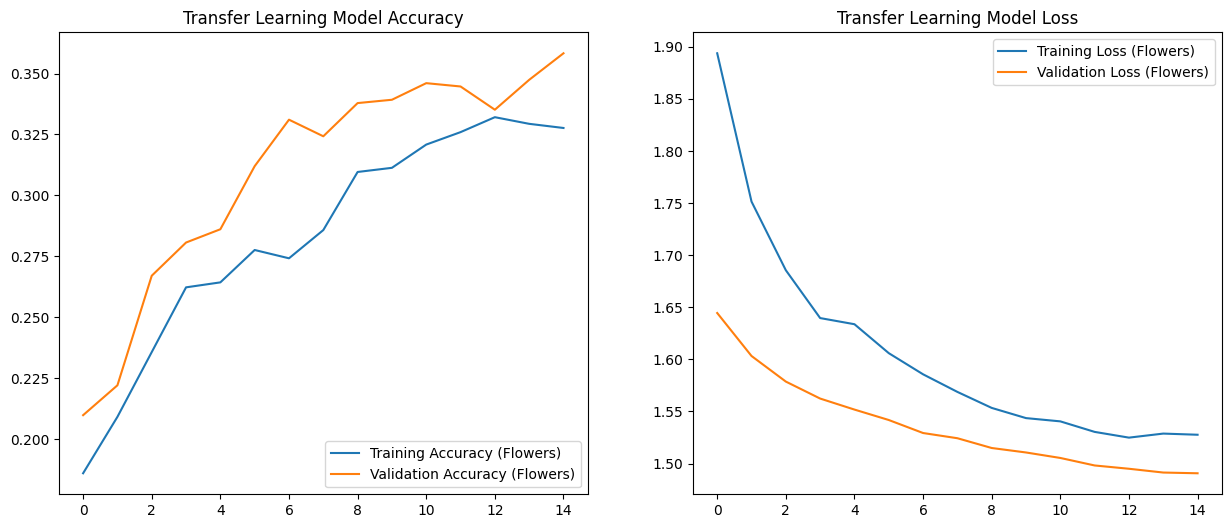

In [13]:
# --- Visualizing the Transfer Learning ---
acc = history_transfer.history['accuracy']
val_acc = history_transfer.history['val_accuracy']
loss = history_transfer.history['loss']
val_loss = history_transfer.history['val_loss']

epochs_range = range(EPOCHS_TRANSFER)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy (Flowers)')
plt.plot(epochs_range, val_acc, label='Validation Accuracy (Flowers)')
plt.legend(loc='lower right')
plt.title('Transfer Learning Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss (Flowers)')
plt.plot(epochs_range, val_loss, label='Validation Loss (Flowers)')
plt.legend(loc='upper right')
plt.title('Transfer Learning Model Loss')
plt.show()

## Testing the Flower Model with Your Own Image

Saving Dandelion.jpg to Dandelion.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Prediction: tulips (Confidence: 25.08%)


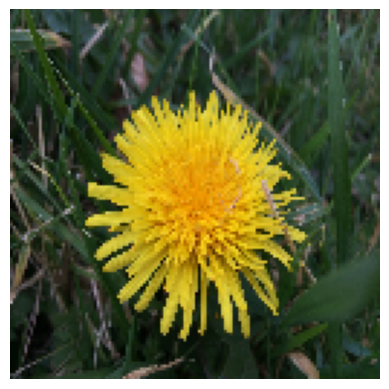

In [14]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

# We need the names of the flower classes
class_names_flowers = metadata_flowers.features['label'].names

# --- Uploading the Image ---
uploaded = files.upload()

for fn in uploaded.keys():

  # --- Loading and Preprocessing the Image ---
  path = fn
  img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
  img_array = img_to_array(img)
  img_array = img_array / 255.0
  img_batch = np.expand_dims(img_array, axis=0)

  # --- Making the Prediction with the transfer model ---
  prediction = transfer_model.predict(img_batch)

  # --- Interpreting the Result for multiple classes ---
  # We find the index of the class with the highest probability
  predicted_class_index = np.argmax(prediction)
  # We use the index to get the class name
  predicted_class_name = class_names_flowers[predicted_class_index]
  # The confidence is the highest probability found
  confidence = np.max(prediction) * 100

  plt.imshow(img)
  plt.axis('off')
  print(f"Prediction: {predicted_class_name} (Confidence: {confidence:.2f}%)")

## Fine-Tuning: The Specialist Awakens

In [15]:
# --- Unfreezing part of the brain ---
# Let's allow the most recent layers of the specialist to be adjusted
loaded_cats_vs_dogs_model.trainable = True

# We freeze the initial layers so as not to lose the basic knowledge
for layer in loaded_cats_vs_dogs_model.layers[:-4]:
    layer.trainable = False

# --- Recompiling with a lower learning rate ---
# For fine-tuning, we use a lower learning rate so as not to
# "spoil" the pre-existing knowledge.
optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=0.0001)

transfer_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer_fine_tune,
    metrics=['accuracy']
)

transfer_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 64)             │     1,698,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flower_output (Dense)           │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,269 (6.48 MB)

 Trainable params: 1,606,021 (6.13 MB)

 Non-trainable params: 93,248 (364.25 KB)

## Training the Model with Fine-Tuning




In [16]:
# --- Training again, now with fine-tuning ---
EPOCHS_FINE_TUNE = 15
total_epochs =  EPOCHS_TRANSFER + EPOCHS_FINE_TUNE

history_fine_tune = transfer_model.fit(train_flowers,
                                       epochs=total_epochs,
                                       initial_epoch=history_transfer.epoch[-1],
                                       validation_data=validation_flowers)

Epoch 15/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3387 - loss: 1.5092 - val_accuracy: 0.3692 - val_loss: 1.4701
Epoch 16/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3498 - loss: 1.5078 - val_accuracy: 0.3924 - val_loss: 1.4515
Epoch 17/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3381 - loss: 1.4828 - val_accuracy: 0.4005 - val_loss: 1.4296
Epoch 18/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3910 - loss: 1.4632 - val_accuracy: 0.4305 - val_loss: 1.4066
Epoch 19/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3816 - loss: 1.4497 - val_accuracy: 0.4414 - val_loss: 1.3884
Epoch 20/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3943 - loss: 1.4223 - val_accuracy: 0.4564 - val_loss: 1.3683
Epoch 21/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4151 - loss: 1.4162 - val_accuracy: 0.4796 - val_loss: 1.3488
Epoch 22/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4244 - loss: 1.3804 - val_accuracy: 0.

## Evaluating the Success of Fine-Tuning

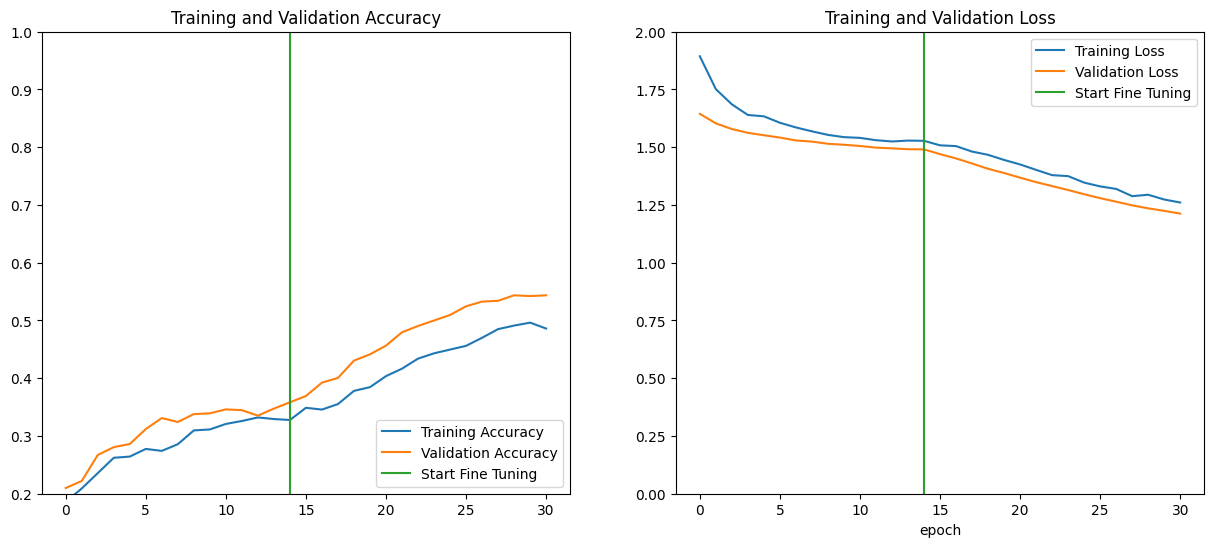

In [17]:
# --- Visualizing learning with Fine-Tuning ---
acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']

loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']


plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 1])
plt.plot([EPOCHS_TRANSFER-1,EPOCHS_TRANSFER-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([EPOCHS_TRANSFER-1,EPOCHS_TRANSFER-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()